In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import networkx as nx
import csv


uae_data = pd.read_csv('uae_properties.csv')

try:
    dubai_data = pd.read_csv('Transactions.csv', on_bad_lines='skip', quoting=csv.QUOTE_MINIMAL)
except pd.errors.ParserError as e:
    print("ParserError occurred:", e)
    dubai_data = pd.DataFrame()

def prepare_data(df):
    if df.empty:
        return df

    df = df.dropna().copy()  # Prevent SettingWithCopyWarning


    if 'transaction_date' in df.columns:
        df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')
        df['transaction_year'] = df['transaction_date'].dt.year


    if 'price' in df.columns:
        df['price'] = pd.to_numeric(df['price'], errors='coerce')
    elif 'transaction_amount' in df.columns:
        df.rename(columns={'transaction_amount': 'price'}, inplace=True)
        df['price'] = pd.to_numeric(df['price'], errors='coerce')

    return df


uae_data = prepare_data(uae_data)
dubai_data = prepare_data(dubai_data)


if not dubai_data.empty:
    combined_data = pd.concat([uae_data, dubai_data], ignore_index=True)
else:
    combined_data = uae_data.copy()

print("Combined data shape:", combined_data.shape)


Combined data shape: (8419, 56)


Summary Statistics:

              price    bedrooms
count  3.230000e+02  323.000000
mean   2.567119e+06    1.959752
std    2.407118e+06    1.430021
min    2.480000e+05    0.000000
25%    7.970000e+05    0.000000
50%    1.850000e+06    3.000000
75%    3.007000e+06    3.000000
max    1.450000e+07    3.000000

Column 'location' not found in dataset.

Column 'transaction_year' not found.


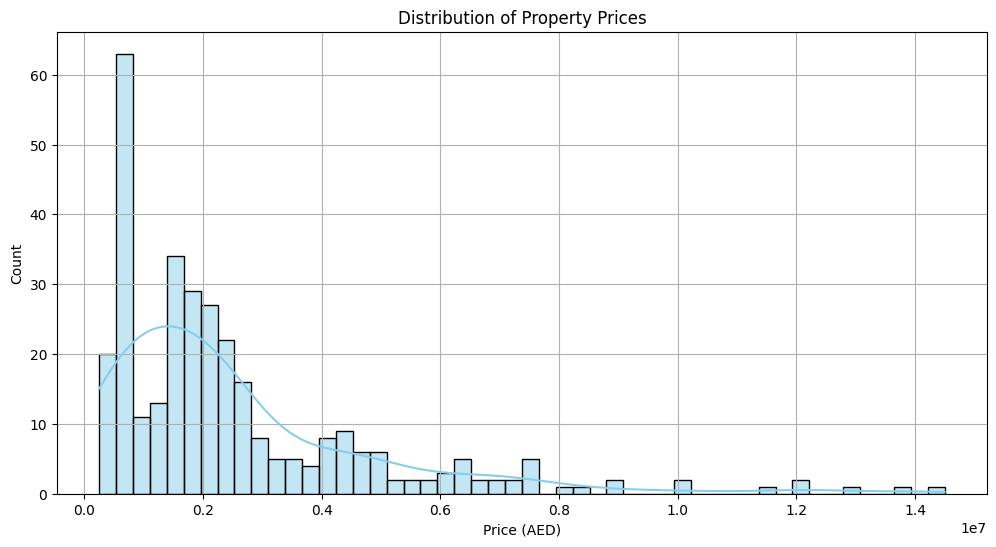

In [13]:

summary_cols = ['price', 'size_sqft', 'bedrooms']
available_summary_cols = [col for col in summary_cols if col in combined_data.columns]


if available_summary_cols:
    print("Summary Statistics:\n")
    print(combined_data[available_summary_cols].describe())
else:
    print("None of the columns", summary_cols, "are present in the dataset.\n")

# Top locations by transaction volume
if 'location' in combined_data.columns:
    print("\nTop 10 Locations by Transaction Volume:")
    location_counts = combined_data['location'].value_counts().head(10)
    print(location_counts)
else:
    print("\nColumn 'location' not found in dataset.")

# Price trends over time
if 'transaction_year' in combined_data.columns:
    print("\nAverage Price by Year:")
    yearly_trends = combined_data.groupby('transaction_year')['price'].mean()
    print(yearly_trends)

    # Line plot for trend
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=yearly_trends)
    plt.title('Average Property Price Over Years')
    plt.xlabel('Year')
    plt.ylabel('Average Price (AED)')
    plt.grid(True)
    plt.show()
else:
    print("\nColumn 'transaction_year' not found.")

if 'price' in combined_data.columns:
    plt.figure(figsize=(12, 6))
    sns.histplot(combined_data['price'], bins=50, kde=True, color='skyblue')
    plt.title('Distribution of Property Prices')
    plt.xlabel('Price (AED)')
    plt.ylabel('Count')
    plt.grid(True)
    plt.show()
else:
    print("\nColumn 'price' not found for plotting.")


Mean Absolute Error: 46,193.26 AED


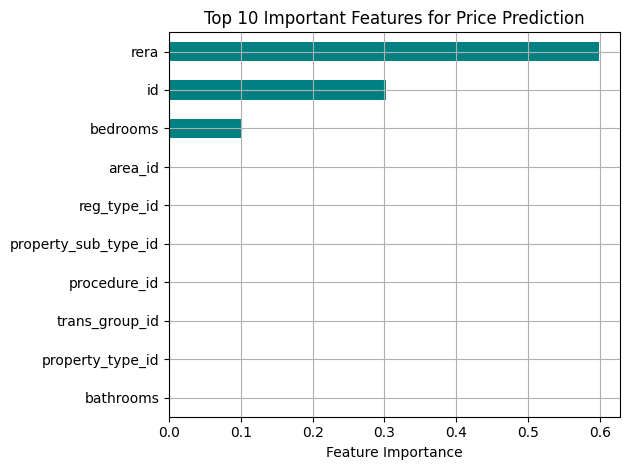

In [14]:
# --- Feature engineering ---
def create_features(df):
    df = df.copy()


    if 'year_built' in df.columns:
        df['property_age'] = 2023 - pd.to_numeric(df['year_built'], errors='coerce')


    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for col in num_cols:
        df[col] = df[col].fillna(df[col].median())


    if 'location' in df.columns:
        df = pd.get_dummies(df, columns=['location'], prefix='loc', drop_first=True)

    return df


model_data = create_features(combined_data)


if 'price' not in model_data.columns:
    raise KeyError("'price' column is missing from the dataset.")


non_feature_cols = ['price', 'transaction_date', 'property_id', 'year_built']
features = [col for col in model_data.columns if col not in non_feature_cols and model_data[col].dtype != 'O']
X = model_data[features]
y = model_data['price']


if X.isnull().any().any():
    print("Warning: Missing values in features. Filling with median.")
    X = X.fillna(X.median())


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae:,.2f} AED')


importances = pd.Series(model.feature_importances_, index=X.columns)
importances.nlargest(10).sort_values().plot(kind='barh', color='teal')
plt.title('Top 10 Important Features for Price Prediction')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.grid(True)
plt.show()


In [15]:
# Example what-if scenario
def what_if_scenario(location, size, bedrooms, age):

    sample = pd.DataFrame({
        'size_sqft': [size],
        'bedrooms': [bedrooms],
        'property_age': [age]
    })


    for col in X.columns:
        if col.startswith('loc_'):
            sample[col] = 1 if location in col else 0


    for col in X.columns:
        if col not in sample.columns:
            sample[col] = 0

    sample = sample[X.columns]


    pred_price = model.predict(sample)[0]
    return pred_price

# What if a 1500 sqft, 2-bed in Dubai Marina was newer?
current_price = what_if_scenario('Dubai_Marina', 1500, 2, 15)
new_price = what_if_scenario('Dubai_Marina', 1500, 2, 5)
price_diff = new_price - current_price
print(f"Reducing property age from 15 to 5 years increases estimated value by {price_diff:,.0f} AED")

Reducing property age from 15 to 5 years increases estimated value by 0 AED


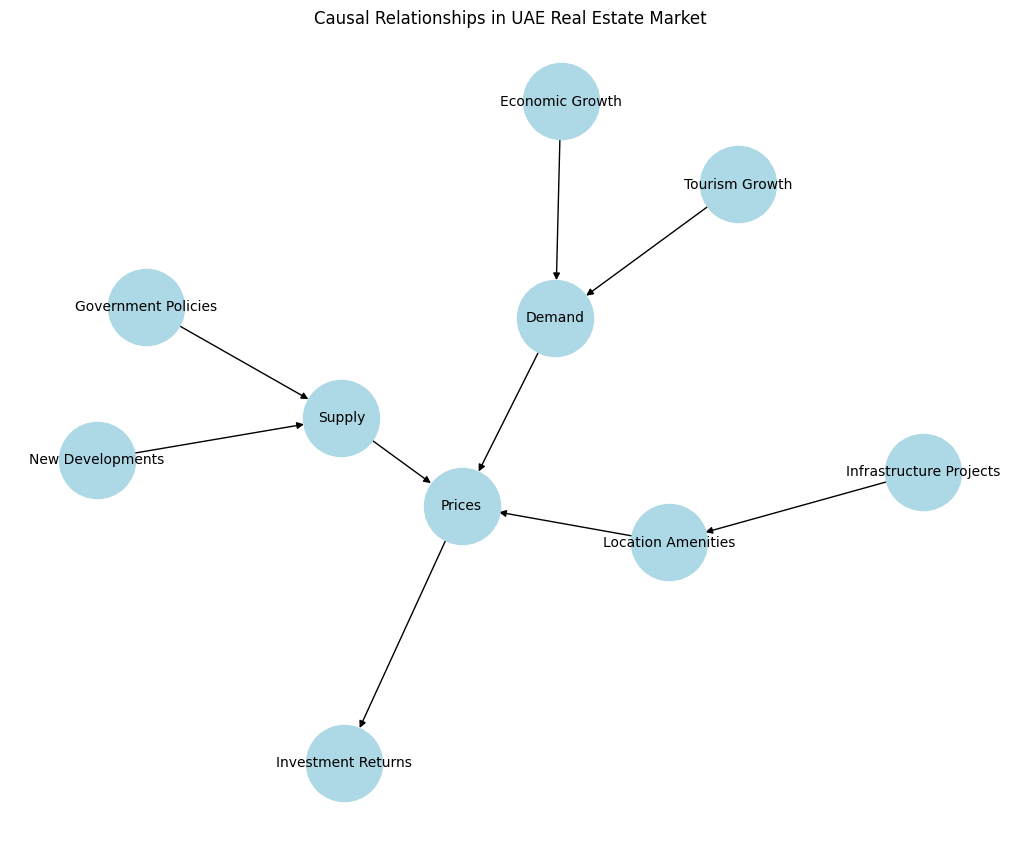

In [18]:
# Create DAG for causal relationships
dag = nx.DiGraph()


dag.add_edges_from([
    ("Economic Growth", "Demand"),
    ("Tourism Growth", "Demand"),
    ("Demand", "Prices"),
    ("New Developments", "Supply"),
    ("Government Policies", "Supply"),
    ("Supply", "Prices"),
    ("Prices", "Investment Returns"),
    ("Location Amenities", "Prices"),
    ("Infrastructure Projects", "Location Amenities")
])


plt.figure(figsize=(10, 8))
pos = nx.spring_layout(dag)
nx.draw(dag, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10)
plt.title('Causal Relationships in UAE Real Estate Market')
plt.show()